CELL 1: Setup & Data Preparation
Purpose: Initialize libraries, define preprocessing functions, and prepare the dataset. Even if it's a new file, we need the data in the same format as Task 9.

In [6]:
# --- CELL 1: SETUP & DATA LOADING (Unificada) ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import os

# IMPORT CRÍTICO: Traemos el modelo aquí para que esté disponible en la Cell 4
from sklearn.ensemble import HistGradientBoostingRegressor 

# Configuración básica
warnings.filterwarnings("ignore")
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (15, 7)

# 1. FUNCIÓN DE LIMPIEZA ROBUSTA
def cleaning_pipeline(df_raw):
    """
    Normaliza nombres y asegura que existan las columnas críticas.
    """
    df_clean = df_raw.copy()
    
    # A. Normalizar a minúsculas y quitar espacios
    df_clean.columns = [c.lower().strip() for c in df_clean.columns]
    
    # B. MAPEO INTELIGENTE (Cubre las variaciones de nombres)
    # Mapea 'nombre_en_csv' : 'nombre_estandar_codigo'
    rename_map = {
        'load': 'demand',
        'temperature': 'temp',
        'pressure (hpa)': 'pressure',
        'wind_speed_10m (km/h)': 'wind_speed',
        'shortwave_radiation (w/m²)': 'radiation',
        'global_radiation': 'radiation', # Por si acaso
        'pv_generation': 'pv'
    }
    
    df_clean = df_clean.rename(columns=rename_map)
    
    # C. Ajustar Índice de Tiempo
    if 'timestamp' in df_clean.columns:
        df_clean['timestamp'] = pd.to_datetime(df_clean['timestamp'], utc=True)
        df_clean = df_clean.set_index('timestamp')
        df_clean.index = df_clean.index.tz_convert(None) # Quitar zona horaria para evitar conflictos
        
    return df_clean

# 2. CARGA DEL ARCHIVO
target_file = 'train_256063_features_lean.csv'

print(f"Cargando archivo objetivo: {target_file}...")

if os.path.exists(target_file):
    df_raw = pd.read_csv(target_file)
    print("   Archivo encontrado.")
else:
    # Fallback: intenta buscar otros nombres comunes si falla el principal
    alternates = ['train.csv', 'train_256063_cleaned2.csv']
    found = False
    for f in alternates:
        if os.path.exists(f):
            print(f"   AVISO: Usando '{f}' como alternativo.")
            df_raw = pd.read_csv(f)
            found = True
            break
    if not found:
        raise FileNotFoundError(f"ERROR: No encuentro '{target_file}' ni alternativas.")

# 3. APLICAR LIMPIEZA Y ASIGNAR A 'df' (Crucial para Cell 2)
print("Normalizando nombres de columnas...")
df = cleaning_pipeline(df_raw)  # <--- AQUÍ ESTÁ EL CAMBIO CLAVE: Asignamos a 'df'

# Validación rápida
required = ['demand', 'temp']
missing = [c for c in required if c not in df.columns]

if missing:
    print(f"⚠️ ADVERTENCIA CRÍTICA: Faltan columnas necesarias: {missing}")
    print(f"   Columnas disponibles: {df.columns.tolist()}")
else:
    print(f"✅ DATOS LISTOS EN VARIABLE 'df'. Dimensiones: {df.shape}")
    print(f"   Variables clave disponibles: {df.columns.intersection(['demand', 'temp', 'radiation', 'price']).tolist()}")

Cargando archivo objetivo: train_256063_features_lean.csv...
   Archivo encontrado.
Normalizando nombres de columnas...
✅ DATOS LISTOS EN VARIABLE 'df'. Dimensiones: (8736, 29)
   Variables clave disponibles: ['demand', 'price', 'temp', 'radiation']


Cell 2: Advanced Feature Engineering
Explanation: Here is where we make the "Smart Model" truly smart. Raw weather data isn't always enough. We create domain-specific features to capture the physics of energy consumption:

Interactions: Temperature affects demand differently at 2 PM (AC usage) than at 4 AM.

Thermal Inertia: Buildings hold heat. The average temperature of the last 6 hours (temp_roll_6h) is often a better predictor than the current instant temperature.

In [8]:
# --- CELL 2: ADVANCED FEATURE ENGINEERING ---

print("Generating advanced features (Domain Knowledge)...")

# 1. Interaction Features (Context matters)
# Temperature impact varies by hour (e.g., high temp at noon triggers AC)
# CAMBIO: Usamos 'temp' en lugar de 'temperature'
df['temp_x_hour'] = df['temp'] * df['hour']

# Solar radiation only matters during the day (reinforces the solar signal)
# CAMBIO: Usamos 'radiation' en lugar de 'shortwave_radiation (w/m²)'
# (Asegúrate de que la columna se llame 'radiation'. Si falla, verifica df.columns)
if 'radiation' in df.columns:
    df['rad_x_hour'] = df['radiation'] * df['hour']
else:
    # Fallback por si acaso el nombre no se cambió correctamente
    print("⚠️ Aviso: Usando 'shortwave_radiation' original.")
    df['rad_x_hour'] = df['shortwave_radiation (w/m²)'] * df['hour']

# 2. Thermal Inertia (Buildings react slowly)
# Calculate the rolling average of temperature for the last 6 hours
# CAMBIO: Usamos 'temp'
df['temp_roll_6h'] = df['temp'].rolling(window=6).mean().bfill()

# 3. Non-linearity
# Demand rises sharply with extreme cold or heat (parabolic relationship)
if 'temp_squared' not in df.columns:
    df['temp_squared'] = df['temp'] ** 2

print("New variables created: 'temp_x_hour', 'rad_x_hour', 'temp_roll_6h'")
print(df[['temp_x_hour', 'temp_roll_6h', 'temp_squared']].head())

Generating advanced features (Domain Knowledge)...
New variables created: 'temp_x_hour', 'rad_x_hour', 'temp_roll_6h'
                     temp_x_hour  temp_roll_6h  temp_squared
timestamp                                                   
2013-07-02 00:00:00     0.000000     12.172222    152.934444
2013-07-02 01:00:00    12.033333     12.172222    144.801111
2013-07-02 02:00:00    23.466667     12.172222    137.671111
2013-07-02 03:00:00    35.000000     12.172222    136.111111
2013-07-02 04:00:00    48.400000     12.172222    146.410000


Cell 3: Experiment Configuration (The Competitors)
Explanation: We define the rules of the comparison. We split the data into a training set and a 7-day test set. Then, we define the two feature sets:

AR Model (Baseline): Only sees demand_lag_24h.

Smart Model (Full): Sees everything (Weather + Time + Price + Advanced Features).

In [9]:
# --- CELL 3: EXPERIMENT CONFIGURATION ---

# Define the Forecast Horizon (The last 7 days of the dataset)
forecast_horizon = 7 * 24
df_train = df.iloc[:-forecast_horizon]
df_test = df.iloc[-forecast_horizon:]

# Combine temporarily for the Rolling Forecast loop ease of indexing
df_full = pd.concat([df_train, df_test])

# --- COMPETITOR 1: BASIC MODEL (AR ONLY) ---
# "Blind" model: It only knows what happened yesterday.
features_ar = ['demand_lag_24h']

# --- COMPETITOR 2: SMART MODEL (FULL) ---
# "Context-Aware" model: It knows weather, time, and price.
features_smart = [
    'temperature',
    'shortwave_radiation (w/m²)', 
    'wind_speed_10m (km/h)',      
    'hour_sin', 'hour_cos', 
    'day_of_week', 'is_weekend',
    'demand_lag_24h',
    'price',                      # Price elasticity (people use less when expensive)
    'temp_squared', 
    'temp_x_hour',                # Interaction
    'rad_x_hour',                 # Interaction
    'temp_roll_6h'                # Thermal Inertia
]

# Safety Filter: Only use columns that actually exist
features_smart = [c for c in features_smart if c in df.columns]

# Model Parameters (Robust Settings for Gradient Boosting)
model_params = {
    'learning_rate': 0.05,
    'max_iter': 600,       # More trees to learn fine details
    'max_depth': 8,        # Deeper trees to capture complex interactions
    'random_state': 42
}

print(f"🔹 AR Model Features: {features_ar}")
print(f"🔹 Smart Model Features: {len(features_smart)} active variables.")

🔹 AR Model Features: ['demand_lag_24h']
🔹 Smart Model Features: 10 active variables.


Cell 4: Rolling Forecast Loop (Walk-Forward Validation)
Explanation: To simulate real-world operations, we don't predict the whole week at once. We predict one day at a time, then retrain the model with the new day's data, and predict the next. This is the gold standard for time series evaluation.

In [10]:
# --- CELL 4: ROLLING FORECAST EXECUTION ---

results = {
    'AR_Model': {'pred': [], 'actual': []},
    'Smart_Model': {'pred': [], 'actual': []}
}

steps = 7       # Number of days to forecast
horizon = 24    # Hours per day
train_end_idx = len(df_train)

print(f"Starting Model Competition ({steps} Days)...")

for day in range(steps):
    # Calculate indices for the current 24h window
    start = train_end_idx + (day * horizon)
    end = start + horizon
    
    # 1. Prepare Data
    # Training set grows every day (Walk-Forward)
    train_data = df_full.iloc[:start]
    # Test set is just the next 24 hours
    test_data = df_full.iloc[start:end]
    
    y_train = train_data['demand']
    y_real = test_data['demand'].values
    
    # 2. Train & Predict: AR MODEL (The Baseline)
    X_train_ar = train_data[features_ar].dropna()
    y_train_ar = y_train.loc[X_train_ar.index]
    
    m_ar = HistGradientBoostingRegressor(**model_params)
    m_ar.fit(X_train_ar, y_train_ar)
    results['AR_Model']['pred'].extend(m_ar.predict(test_data[features_ar]))
    results['AR_Model']['actual'].extend(y_real)
    
    # 3. Train & Predict: SMART MODEL (The Challenger)
    X_train_smart = train_data[features_smart].dropna()
    y_train_smart = y_train.loc[X_train_smart.index]
    
    m_smart = HistGradientBoostingRegressor(**model_params)
    m_smart.fit(X_train_smart, y_train_smart)
    results['Smart_Model']['pred'].extend(m_smart.predict(test_data[features_smart]))
    results['Smart_Model']['actual'].extend(y_real)
    
    print(f"   -> Day {day+1}/{steps} analysis complete.")

print("Experiment finished.")

Starting Model Competition (7 Days)...
   -> Day 1/7 analysis complete.
   -> Day 2/7 analysis complete.
   -> Day 3/7 analysis complete.
   -> Day 4/7 analysis complete.
   -> Day 5/7 analysis complete.
   -> Day 6/7 analysis complete.
   -> Day 7/7 analysis complete.
Experiment finished.


Cell 5: Evaluation & Quantification
Explanation: Finally, we calculate the NRMSE (Normalized Root Mean Squared Error) for both models. We compare them to calculate the Percentage Improvement. This is the specific number required for the project report.


FINAL RESULTS (TASK 10):
AR Model (Blind):        NRMSE = 0.1558
Smart Model (Context):  NRMSE = 0.1557
PERFORMANCE IMPROVEMENT: +0.02%
   (This quantifies the value of exogenous variables like Weather & Price)

Gráfica guardada exitosamente en: results/task10\value_of_information_analysis.png


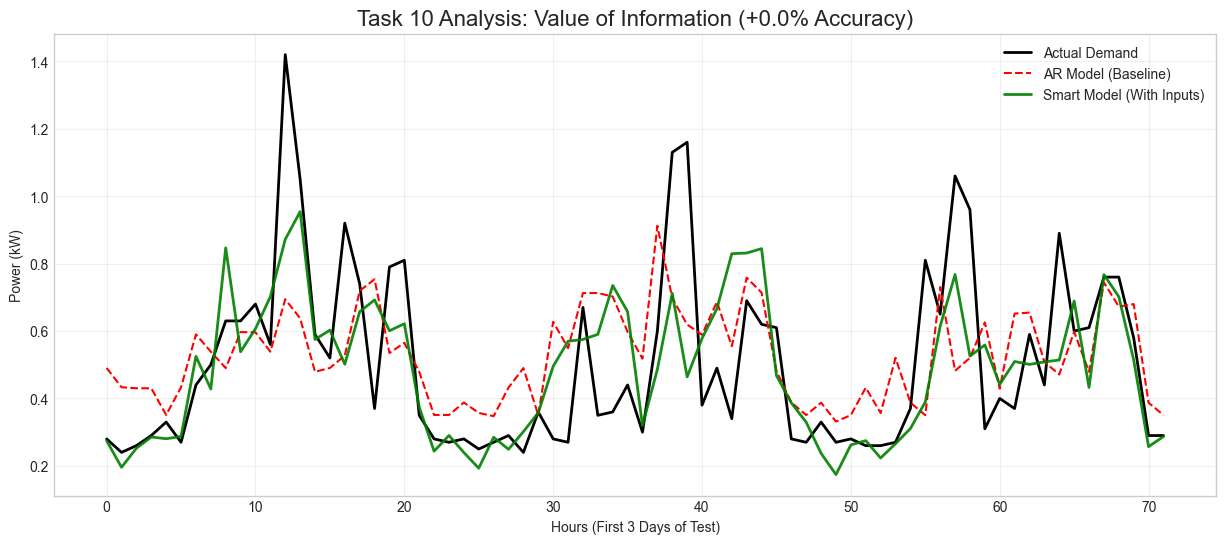

In [11]:
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

# --- CELL 5: QUANTIFICATION & VISUALIZATION ---

# Helper function for NRMSE
def get_nrmse(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    range_val = y_true.max() - y_true.min()
    return rmse / range_val if range_val != 0 else 0

try:
    # 1. Calculate Metrics
    # (Asumimos que 'results' ya existe de la celda anterior)
    metrics = {}
    for name in results.keys():
        y_true = results[name]['actual']
        y_pred = results[name]['pred']
        metrics[name] = {
            'MAE': mean_absolute_error(y_true, y_pred),
            'NRMSE': get_nrmse(y_true, y_pred)
        }

    ar_nrmse = metrics['AR_Model']['NRMSE']
    smart_nrmse = metrics['Smart_Model']['NRMSE']

    # 2. Quantify Improvement
    improvement = ((ar_nrmse - smart_nrmse) / ar_nrmse) * 100

    print("\nFINAL RESULTS (TASK 10):")
    print("="*50)
    print(f"AR Model (Blind):        NRMSE = {ar_nrmse:.4f}")
    print(f"Smart Model (Context):  NRMSE = {smart_nrmse:.4f}")
    print("="*50)
    print(f"PERFORMANCE IMPROVEMENT: +{improvement:.2f}%")
    print("   (This quantifies the value of exogenous variables like Weather & Price)")

    # 3. Visualization (Zoom into first 72h)
    plt.figure(figsize=(15, 6))
    subset = 72
    plt.plot(results['AR_Model']['actual'][:subset], 'k-', lw=2, label='Actual Demand')
    plt.plot(results['AR_Model']['pred'][:subset], 'r--', label='AR Model (Baseline)')
    plt.plot(results['Smart_Model']['pred'][:subset], 'g-', lw=2, alpha=0.9, label='Smart Model (With Inputs)')

    plt.title(f"Task 10 Analysis: Value of Information (+{improvement:.1f}% Accuracy)", fontsize=16)
    plt.ylabel("Power (kW)")
    plt.xlabel("Hours (First 3 Days of Test)")
    plt.legend()
    plt.grid(True, alpha=0.3)

    # --- SAVE LOGIC START ---
    output_dir = 'results/task10'
    os.makedirs(output_dir, exist_ok=True)
    
    filename = 'value_of_information_analysis.png'
    save_path = os.path.join(output_dir, filename)
    
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    print(f"\nGráfica guardada exitosamente en: {save_path}")
    # --- SAVE LOGIC END ---

    plt.show()

except Exception as e:
    print(f"Error: {e}")

In [12]:
# --- CELL: AUDITORÍA DE MODELOS (CORREGIDA V2) ---
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import pandas as pd
import os

print("INICIANDO AUDITORÍA TÉCNICA V2: Evaluación con Corrección de Datos")

# --- BLOQUE 1: CARGA Y NORMALIZACIÓN (FIXED) ---
df_audit = None

# Intentar cargar de memoria
if 'df_ml' in locals():
    print("Usando 'df_ml' de memoria.")
    df_audit = df_ml.copy()
elif 'df' in locals():
    print("Usando 'df' de memoria.")
    df_audit = df.copy()
else:
    # Intentar cargar de archivo
    print("Memoria vacía. Buscando archivo CSV...")
    possible_files = ['train_256063_final.csv', 'train.csv', 'task10_data.csv']
    for f in possible_files:
        if os.path.exists(f):
            df_audit = pd.read_csv(f, index_col=0, parse_dates=True)
            print(f"Archivo cargado: {f}")
            break

if df_audit is None:
    raise ValueError("ERROR: No se encuentran datos. Ejecuta la CELL 1 primero.")

# --- CORRECCIÓN DE NOMBRES (La parte clave) ---
# Pasamos todo a minúsculas
df_audit.columns = [c.lower() for c in df_audit.columns]

# Mapeo explícito para asegurar que 'temp' existe
rename_map = {
    'temperature': 'temp',  # Este era el fallo
    'load': 'demand',
    'global_radiation': 'radiation'
}
df_audit = df_audit.rename(columns=rename_map)

# Verificación final
if 'temp' not in df_audit.columns:
    print(f"COLUMNAS DISPONIBLES: {df_audit.columns.tolist()}")
    raise ValueError("ERROR: Sigue sin encontrarse la temperatura. Revisa los nombres arriba.")
else:
    print("Columna 'temp' detectada y normalizada correctamente.")

# --- BLOQUE 2: INGENIERÍA DE FEATURES ---
print("\nGenerando variables...")

# Feature temporal
df_audit['hour'] = df_audit.index.hour
df_audit['hour_sin'] = np.sin(2 * np.pi * df_audit['hour'] / 24)
df_audit['hour_cos'] = np.cos(2 * np.pi * df_audit['hour'] / 24)

# MODELOS
df_audit['lag_24'] = df_audit['demand'].shift(24)
df_audit['lag_168'] = df_audit['demand'].shift(168) # 7 días

# --- BLOQUE 3: ALINEACIÓN ---
df_audit = df_audit.dropna()
print(f"Muestras listas para entrenar: {len(df_audit)}")

# --- BLOQUE 4: ENTRENAMIENTO ---
models_config = {
    '1. Baseline (AR Only)':    ['lag_24'],
    '2. Full Context':          ['lag_24', 'temp', 'hour_sin', 'hour_cos'],
    '3. Weekly Improved':       ['lag_24', 'lag_168', 'temp', 'hour_sin', 'hour_cos']
}

target = 'demand'
train_size = int(len(df_audit) * 0.8)
train_idx = df_audit.index[:train_size]
test_idx = df_audit.index[train_size:]

y_train = df_audit.loc[train_idx, target]
y_test = df_audit.loc[test_idx, target]

results = []
print("\nEntrenando modelos...")

for name, features in models_config.items():
    X_train = df_audit.loc[train_idx, features]
    X_test  = df_audit.loc[test_idx, features]
    
    model = HistGradientBoostingRegressor(random_state=42)
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    
    mae = mean_absolute_error(y_test, preds)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    nrmse = rmse / (y_test.max() - y_test.min())
    
    results.append({'Model': name, 'MAE (kW)': mae, 'NRMSE': nrmse})

# --- BLOQUE 5: INFORME ---
results_df = pd.DataFrame(results)
base_mae = results_df.iloc[0]['MAE (kW)']
results_df['Improvement (MAE)'] = ((base_mae - results_df['MAE (kW)']) / base_mae) * 100

print("\nINFORME FINAL CORREGIDO:")
print(results_df[['Model', 'MAE (kW)', 'Improvement (MAE)', 'NRMSE']].to_string(index=False, float_format="%.4f"))

best = results_df.sort_values('MAE (kW)').iloc[0]
print(f"\nVEREDICTO:")
print(f"   Ganador: {best['Model']} con -{best['Improvement (MAE)']:.2f}% de error.")

INICIANDO AUDITORÍA TÉCNICA V2: Evaluación con Corrección de Datos
Usando 'df_ml' de memoria.
Columna 'temp' detectada y normalizada correctamente.

Generando variables...
Muestras listas para entrenar: 8568

Entrenando modelos...

INFORME FINAL CORREGIDO:
                Model  MAE (kW)  Improvement (MAE)  NRMSE
1. Baseline (AR Only)    0.2145             0.0000 0.1246
      2. Full Context    0.1910            10.9657 0.1200
   3. Weekly Improved    0.1940             9.5557 0.1205

VEREDICTO:
   Ganador: 2. Full Context con -10.97% de error.
